<a href="https://colab.research.google.com/github/Rugiyya1/Kaggle_projects/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [5]:
#mnist is the dataset of images of digits handritten by students and people / 'Hello World' of ML dataset :))


In [6]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [7]:
X, y = mnist['data'], mnist['target']

In [8]:
X.shape

(70000, 784)

In [9]:
#X=pd.DataFrame(X)
#X.head()

In [10]:
#y=pd.DataFrame(y)

In [11]:
y.shape

(70000,)

In [12]:
## there are 70000 images, eac image has 784 features(28x28 pixel images)

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt


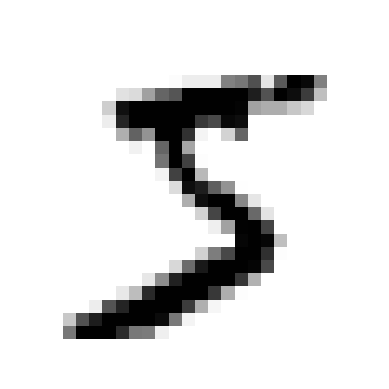

In [14]:
some_digit =X[0]

some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()


In [15]:
#picture looks like 5, let's check label
y[0]

'5'

In [16]:
## label is string, convert to int
y=y.astype(np.uint8)

In [17]:
# MNIST dataset is already split into train and test set. training set is already shuffled

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

#Training a Binary Classifier

In [18]:
#to simplify the problem, trying to identify one digit (eg 5)

y_train_5 =(y_train==5)
y_test_5=(y_test==5)

In [19]:
## using Stochastic Gradient Descent (SGD) classiffier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [20]:
sgd_clf.predict([some_digit])

array([ True])

In [21]:
## the model predicted 5 correctly

## Performance Measures

In [22]:
## evaluating a classifier is often trickier than a regressor.


In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [24]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf=clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred =clone_clf.predict(X_test_fold)
  n_correct =sum(y_pred == y_test_fold)
  print(n_correct/len(y_pred))



0.9669
0.91625
0.96785


In [25]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [26]:
## classifying every single image in the 'not-5' class

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self,X, y=None):
    pass
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)


In [27]:
never_5_clf =Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [28]:
## it shows that only 10% of images are 5s, (like imbalanced data)/ so accuracy is not best preffered measure for classifiers always

In [29]:
## Confusion Matrix

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [30]:
## cross_val_predict performs K-fold cross-validation like cross_val_score(), but it returns predictions made on each test fold (instead of evaluation scores)

In [31]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [32]:
# Precision and recall

from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [33]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [34]:
# above results shows that although your model is correct 83.7%, recall shows that it only detects 65% of 5s.
## recall and precision is combined into single metrics F1score. F1 is harmonic mean
#F1 will be high ii both recall and precision are high

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [35]:
#threshold cannot set directly, decition_function can help to set threshold

y_scores=sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [36]:
threshold=0
y_some_digit_pred =(y_scores >threshold)
y_some_digit_pred

array([ True])

In [37]:
## increase threshold
threshold=8000
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([False])

In [38]:
## although our digit is 5, increasing threshold decreased recall, so our model didnt capture this 5

In [39]:
## how to decide which threshold to use
y_scores=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                           method='decision_function')

In [40]:
#compute precisiona and recall for all possible thresholds (using precision_recall_curve())

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

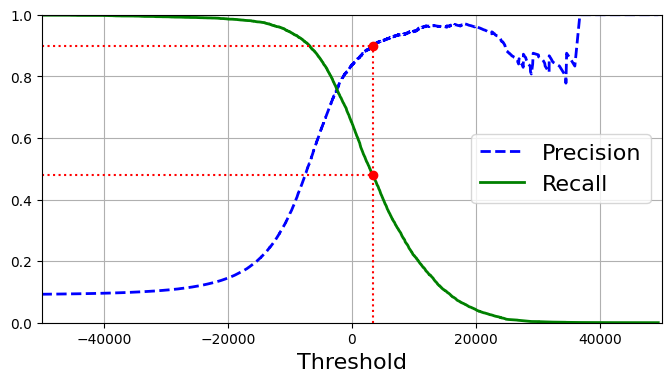

In [45]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], 'b--', label='Precision',linewidth=2)
  plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)
  plt.legend(loc="center right", fontsize=16) #
  plt.xlabel("Threshold", fontsize=16)        #
  plt.grid(True)                              #
  plt.axis([-50000, 50000, 0, 1])             #

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show()

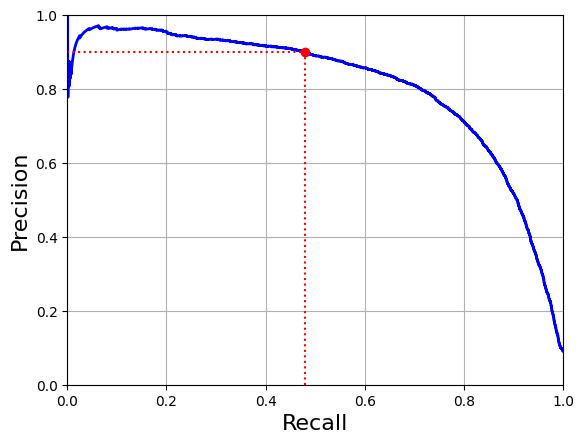

In [55]:
# another way to show precision/recall trade-off - direct plot

plt.plot(recalls , precisions, "b-", linewidth=2)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.axis([0, 1, 0, 1])
plt.grid(True)


In [69]:
#finding lowest threshold gives 90% precsions
threshold_90_precision=thresholds[np.argmax(precisions >= 0.9)]
threshold_90_precision

3370.0194991439557

In [70]:
## making predictions on the training set

y_train_pred_90 =(y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [71]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [72]:
## as it is shown, it is easy to get precision we want for classifiers, however, high precision is not useful if recall is low

###ROC curve

In [75]:
## Receiver Operating Curve - common tool for binary classifiers. Similar to precision/recall curve
## ROC plot recall (true positive rate) against false positive rate


In [76]:
from sklearn.metrics import roc_curve

In [77]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

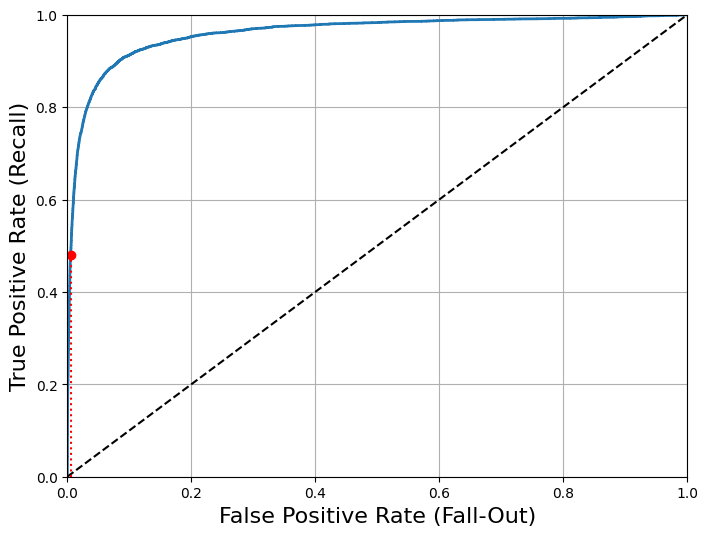

In [83]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
  plt.axis([0, 1, 0, 1])
  plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
  plt.ylabel('True Positive Rate (Recall)', fontsize=16)
  plt.grid(True)


plt.figure(figsize=(8, 6))                                    #
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           #
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   #
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  #
plt.plot([fpr_90], [recall_90_precision], "ro")               #
plt.show()